In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn
from IPython.display import clear_output, display, Video
from torch_cluster import knn
from torch_geometric.nn import Linear, Sequential
from torch_geometric.nn.conv import MessagePassing, GENConv
from tqdm import tqdm

sys.path.append('../src')
from models import NPA
from nets import GCN, MLP
from util import get_particles, grab_plot, show_particles, VideoWriter

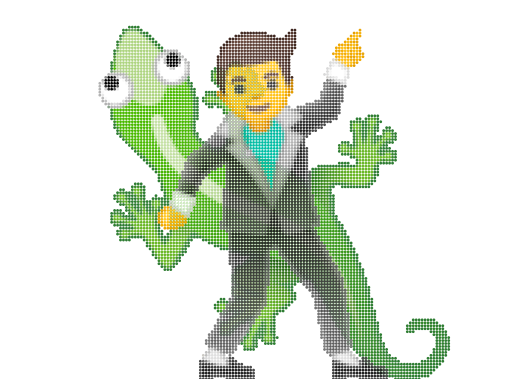

In [2]:
SEED_PATH = '../images/lizard.png'
TARGET_PATH = '../images/dancer.png'

seed = get_particles(SEED_PATH, n_channels=16, threshold=1., randomize=True)
target = get_particles(TARGET_PATH)
show_particles(seed, target)

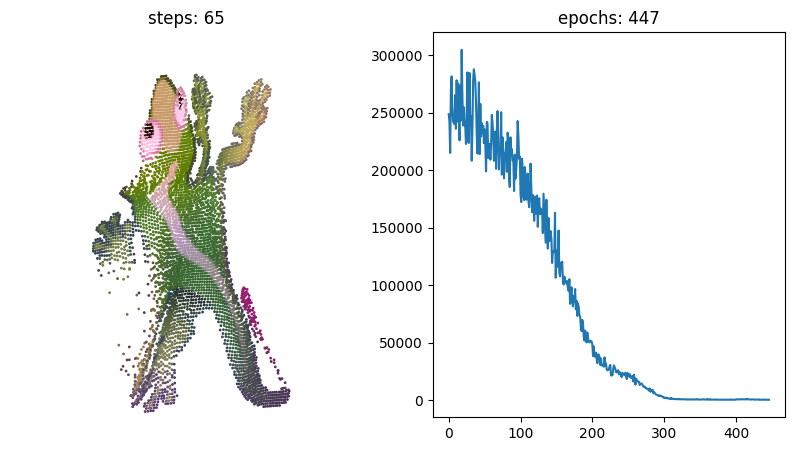

 11%|█         | 447/4000 [54:51<7:16:03,  7.36s/it]


KeyboardInterrupt: 

In [4]:
N_NEIGHBORS = 8
MLP_CHANNELS = (128, 256, 256, 128)
OUT_CHANNELS = (64, 64)

model = NPA(N_NEIGHBORS, MLP_CHANNELS, OUT_CHANNELS)
model.fit(seed, target);

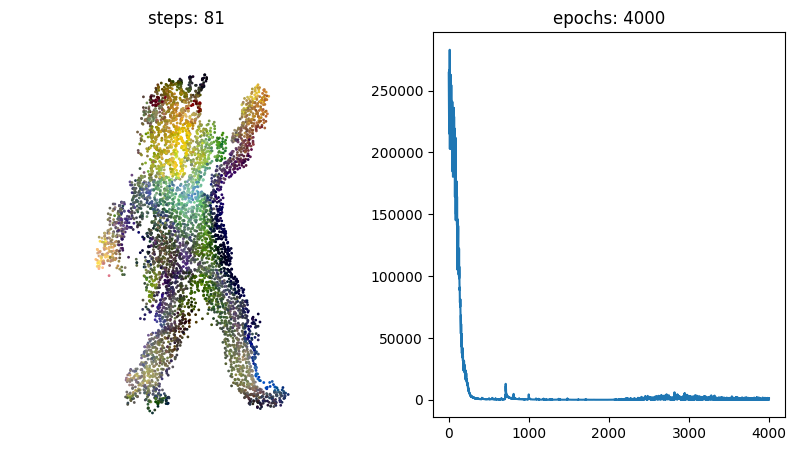

100%|██████████| 4000/4000 [7:01:31<00:00,  6.32s/it]


: 

In [ ]:
model = NPA()
model.train(seed, target);

In [ ]:
x = seed.clone()

with VideoWriter(path='../videos/sandbox_autoplay.mp4') as video:
    for _ in tqdm(range(100)):
        show_particles(x.detach(), show=False)
        video.write(grab_plot())
        x = model(x, update_rate=1e-3)

 74%|███████▍  | 369/500 [00:43<00:15,  8.58it/s]

: 